# Oracle CPU analysis

Datafile: a csv file exporting the data of the Kibana visualization **tomeu_racprod_cpu_free_beforeapplying_x100_div24** Export as Formatted!


## Read the datafile, make some cleaning and transformation.


In [1]:
import pandas as pd

df = pd.read_csv('./data/racprod_cpu_2020_November.csv',
                 index_col='timestamp_per_hour',
                 parse_dates=['timestamp_per_hour'],
                 date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')
                )

df['idle_cpu_pct'] = df.avg_cpu_idle_pct*100/24
df['used_cpu_pct'] = 100 - df.idle_cpu_pct


In [2]:
df.sort_index(inplace=True)
#df.sort_index(ascending=False)
df.head()

,host_name,avg_cpu_idle_pct,idle_cpu_pct,used_cpu_pct
timestamp_per_hour,,,,
2020-11-01 00:00:00,srvmtszrh042.mts.pri,9.285,38.687500,61.312500
2020-11-01 00:00:00,srvmtszrh040.mts.pri,6.676,27.816667,72.183333
2020-11-01 01:00:00,srvmtszrh042.mts.pri,8.780,36.583333,63.416667
2020-11-01 01:00:00,srvmtszrh040.mts.pri,3.831,15.962500,84.037500
2020-11-01 02:00:00,srvmtszrh042.mts.pri,8.068,33.616667,66.383333


In [3]:
# We drop the columns that we won't need for the analysis.
df.drop(columns=['avg_cpu_idle_pct','idle_cpu_pct'],inplace=True)
df.head()

,host_name,used_cpu_pct
timestamp_per_hour,,
2020-11-01 00:00:00,srvmtszrh042.mts.pri,61.312500
2020-11-01 00:00:00,srvmtszrh040.mts.pri,72.183333
2020-11-01 01:00:00,srvmtszrh042.mts.pri,63.416667
2020-11-01 01:00:00,srvmtszrh040.mts.pri,84.037500
2020-11-01 02:00:00,srvmtszrh042.mts.pri,66.383333


## Period of time analyzed:

In [4]:
print( 'From:', df.index.min() )
print( '  To:', df.index.max() )


From: 2020-11-01 00:00:00
  To: 2020-11-30 23:00:00


# Analysis of the used CPU of each database server.

In [5]:
df_pivot = pd.pivot_table(df, index='timestamp_per_hour', values='used_cpu_pct', columns=['host_name'], aggfunc='sum')
df_pivot.head()

host_name,srvmtszrh040.mts.pri,srvmtszrh042.mts.pri
timestamp_per_hour,,
2020-11-01 00:00:00,72.183333,61.312500
2020-11-01 01:00:00,84.037500,63.416667
2020-11-01 02:00:00,76.858333,66.383333
2020-11-01 03:00:00,84.466667,68.729167
2020-11-01 04:00:00,74.333333,60.966667


## 1. Used CPU for each server.

In [6]:
df_pivot.plot(kind='line', grid=True, ylim=(0,100), subplots=True, figsize=(20,10) )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ac17f28>,
      dtype=object)

***Use of CPU of each server in the same plot.***

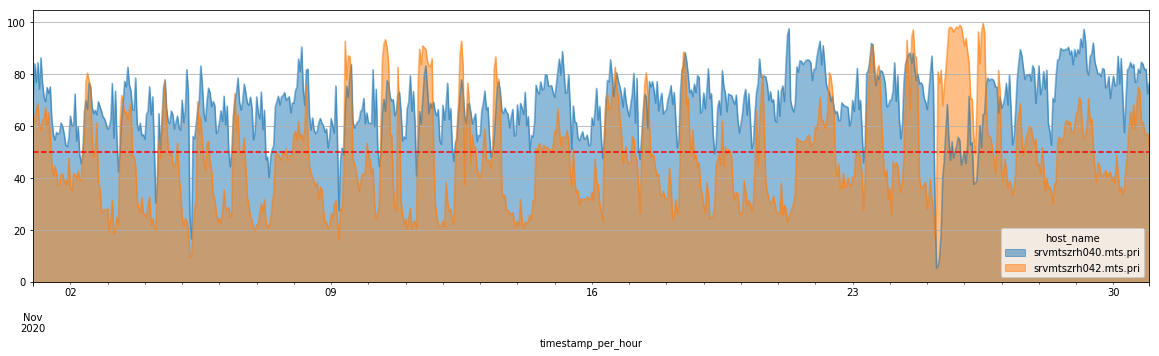

In [7]:
plot = df_pivot.plot.area(figsize=(20,5), grid=True, stacked=False)
plot.axhline(y=50, color='red', linestyle='--')

## 2. What if one server is down?

The following plot is a stacked line plot that displays the ***CPU consumption of the sum of the 2 servers**.

All periods having a sum of more than 100%, are the periods that a single server would not be able to cope with the whole workload, meaning that the performance would be so low that more of the business platforms, users, clients, etc., could have the feeling that the systems are down.

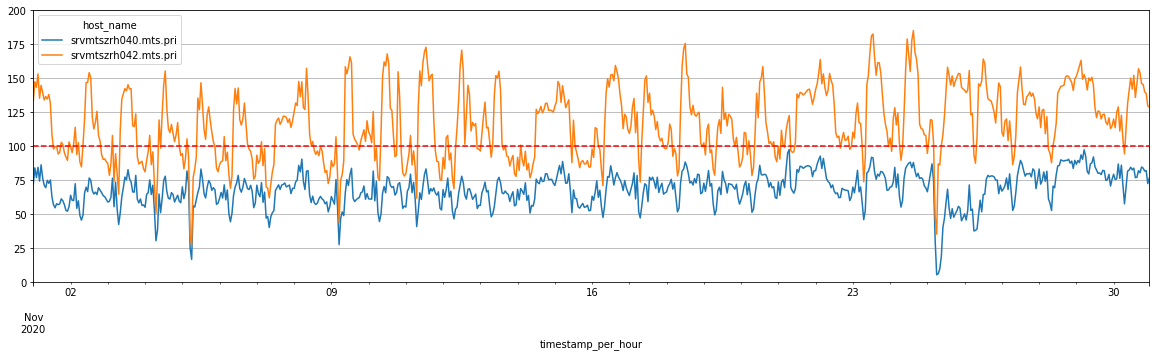

In [8]:
plot = df_pivot.plot(kind='line', grid=True, ylim=(0,200), figsize=(20,5), stacked=True)
plot.axhline(y=100, color='red', linestyle='--')

### What is the pattern of the CPU load during working hours and weehdays?

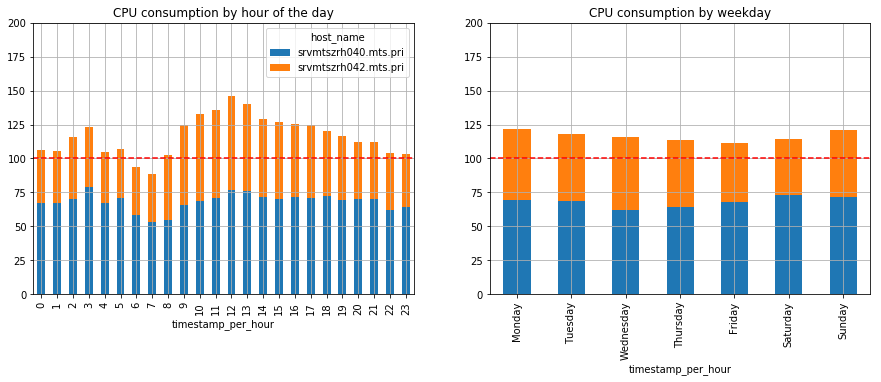

In [9]:
import matplotlib.pyplot as plt

df_pivot.head()
#df_pivot.resample(rule='H').mean()

fig, axes = plt.subplots(nrows=1,ncols=2)

# CPU consumption by hour of the day
df_hourly = df_pivot.groupby(df_pivot.index.hour).mean()
h = df_hourly.plot(ax = axes[0],kind='bar', grid=True, ylim=(0,200), stacked=True, title='CPU consumption by hour of the day')
h.axhline(y=100, color='red', linestyle='--')

# CPU consumption by weekday
df_weekday = df_pivot.groupby(df_pivot.index.weekday_name).mean()

# The following shit, until plotting, is for ordering the weekdays!!!
# http://blog.quizzicol.com/2016/10/03/sorting-dates-in-python-by-day-of-week/
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
df_weekday['Day_id'] = df_weekday.index
df_weekday['Day_id'] = df_weekday['Day_id'].map(sorterIndex)
df_weekday.sort_values('Day_id', inplace=True)
df_weekday.drop(['Day_id'], axis=1, inplace=True)

wd = df_weekday.plot(ax = axes[1], kind='bar', grid=True, ylim=(0,200), legend=False, figsize=(15,5), stacked=True, title='CPU consumption by weekday')
wd.axhline(y=100, color='red', linestyle='--')

#df_weekday

## 3. Statistical analysis of the data samples 

Quick overview of data statistics: number of samples, mean, desviation, ...

In [10]:
df_pivot.describe()

host_name,srvmtszrh040.mts.pri,srvmtszrh042.mts.pri
count,720.000000,720.000000
mean,68.362726,48.417135
std,12.405351,19.441843
min,5.425000,9.495833
25%,61.178125,32.246875
50%,69.143750,45.960417
75%,76.610417,59.619792
max,97.533333,99.612500


In [11]:
df_pivot.median()

host_name
srvmtszrh040.mts.pri    69.143750
srvmtszrh042.mts.pri    45.960417
dtype: float64

**How is the data distributed?**

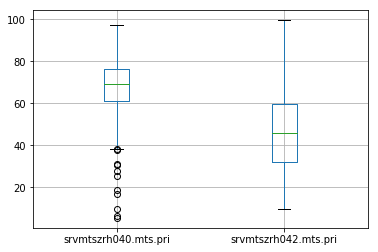

In [12]:
df_pivot.boxplot()

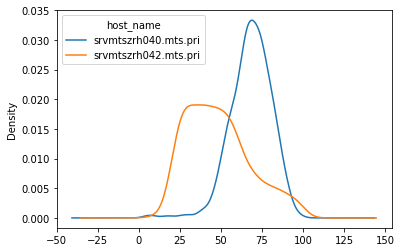

In [13]:
df_pivot.plot.density()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dd36be0>,
      dtype=object)

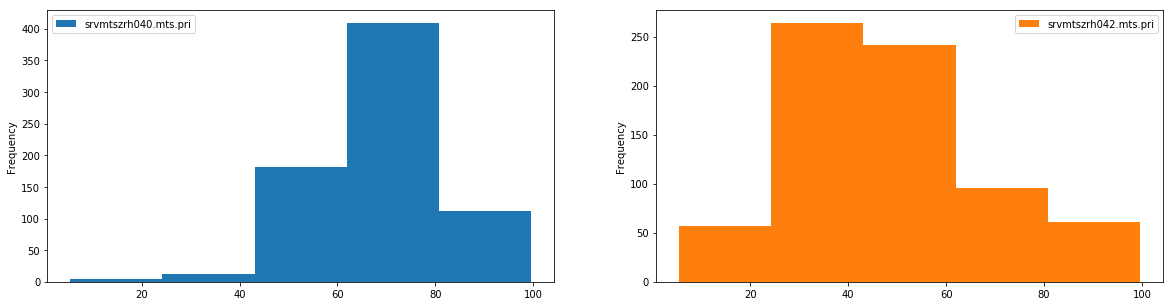

In [14]:
df_pivot.plot.hist(bins=5, subplots=True, layout=(1,2), figsize=(20,5))